In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
import math



# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [10]:
# Define improved transformations - less aggressive augmentation
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)
])
transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),  # No random crop for validation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load dataset
train_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/train", transform=transform_train)
loaded_train = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

validation_data = datasets.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/validation", transform=transform_val)
loaded_validation = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [11]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        
        # Initial feature extraction
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Convolutional blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.5)
        )

        # Squeeze-and-excitation blocks
        self.se1 = SEBlock(128)
        self.se2 = SEBlock(256)
        self.se3 = SEBlock(512)

        # Shortcut projections for residual connections
        self.shortcut1 = nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False)
        self.shortcut2 = nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=False)

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 7)
        )

    def forward(self, x):
        # Initial features
        x = self.initial(x)

        # Residual block 1 with SE
        identity1 = self.shortcut1(x)
        x = self.conv1(x)
        x = self.se1(x)
        x = x + identity1

        # Residual block 2 with SE
        identity2 = self.shortcut2(x)
        x = self.conv2(x)
        x = self.se2(x)
        x = x + identity2

        # Residual block 3 with SE
        x = self.conv3(x)
        x = self.se3(x)

        # Global pooling and classification
        x = self.avgpool(x)
        x = self.fc(x)
        return x


Starting training...
Epoch [1/100] Batch [440/451] Loss: 1.8562 LR: 0.000043
Epoch [1/100]
Train Loss: 1.8579, Train Acc: 23.39%
Val Loss: 1.8162, Val Acc: 28.04%
Per-class accuracies: {0: '0.00%', 1: '0.00%', 2: '0.00%', 3: '88.93%', 4: '0.08%', 5: '3.69%', 6: '39.52%'}
Epoch [2/100] Batch [440/451] Loss: 1.7344 LR: 0.000050
Epoch [2/100]
Train Loss: 1.8050, Train Acc: 27.40%
Val Loss: 1.7495, Val Acc: 31.73%
Per-class accuracies: {0: '0.00%', 1: '0.00%', 2: '0.29%', 3: '95.01%', 4: '1.48%', 5: '7.73%', 6: '50.06%'}
Epoch [3/100] Batch [440/451] Loss: 1.6731 LR: 0.000063
Epoch [3/100]
Train Loss: 1.7356, Train Acc: 32.81%
Val Loss: 1.6528, Val Acc: 39.99%
Per-class accuracies: {0: '0.00%', 1: '0.00%', 2: '3.63%', 3: '67.62%', 4: '25.99%', 5: '66.64%', 6: '60.23%'}
Epoch [4/100] Batch [440/451] Loss: 1.6967 LR: 0.000081
Epoch [4/100]
Train Loss: 1.6616, Train Acc: 37.27%
Val Loss: 1.5630, Val Acc: 43.11%
Per-class accuracies: {0: '0.73%', 1: '0.00%', 2: '3.63%', 3: '81.64%', 4: '53.12%

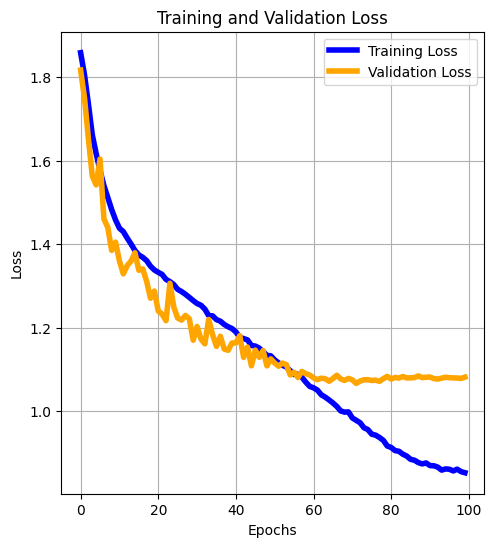

In [15]:
# Validation loss calculation
def compute_validation_loss():
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in loaded_validation:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(loaded_validation)

# Initialize model, loss, and optimizer with better configurations
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Increased label smoothing
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.05)  # Lower initial LR, higher weight decay

# More sophisticated learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    epochs=100,
    steps_per_epoch=len(loaded_train),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1000.0
)

# Mixed precision scaler
scaler = torch.amp.GradScaler("cuda")

# Initialize loss tracking with early stopping
train_losses = []
val_losses = []
best_val_acc = 0
patience = 15  # Increased patience
patience_counter = 0
best_model_state = None

def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 7
    class_total = [0] * 7
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with torch.amp.autocast("cuda"):
                outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-class accuracy
            for i in range(7):
                mask = labels == i
                class_correct[i] += (predicted[mask] == labels[mask]).sum().item()
                class_total[i] += mask.sum().item()
    
    return 100 * correct / total, [100 * c/t if t > 0 else 0 for c, t in zip(class_correct, class_total)]

def train_part(model, optimizer, epochs=100):
    global best_val_acc, patience_counter, best_model_state
    torch.backends.cudnn.benchmark = True
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(loaded_train):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # Clear gradients
            for param in model.parameters():
                param.grad = None
            
            # Mixed precision training
            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Gradient scaling and optimization
            scaler.scale(loss).backward()
            
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()  # Update LR each batch
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 20 == 0:  # Print progress every 20 batches
                print(f'Epoch [{epoch+1}/{epochs}] Batch [{i}/{len(loaded_train)}] '
                      f'Loss: {loss.item():.4f} LR: {scheduler.get_last_lr()[0]:.6f}', end='\r')
        
        # Calculate metrics
        train_loss = running_loss / len(loaded_train)
        train_acc = 100 * correct / total
        val_loss = compute_validation_loss()
        val_acc, class_accs = evaluate_model(model, loaded_validation)
        
        # Save losses for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'val_acc': val_acc,
            }, 'best_model.pth')
        else:
            patience_counter += 1
        
        # Print epoch statistics
        print(f"\nEpoch [{epoch+1}/{epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print("Per-class accuracies:", {k: f"{v:.2f}%" for k, v in enumerate(class_accs)})
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
        
        # Clear GPU cache periodically
        if epoch % 5 == 0:
            torch.cuda.empty_cache()
    
    # Plot training history with improved visualization
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 1, 1)
    plt.plot(train_losses, label="Training Loss", color='blue', linewidth=4)
    plt.plot(val_losses, label="Validation Loss", color='orange', linewidth=4)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title("Training and Validation Loss")
    
    # Load best model
    model.load_state_dict(best_model_state)
    print(f"\nBest validation accuracy: {best_val_acc:.2f}%")
    return model

print("Starting training...")
model = train_part(model, optimizer)
print("Training complete!")

# Final evaluation
val_accuracy, class_accuracies = evaluate_model(model, loaded_validation)
print(f'Final Validation Accuracy: {val_accuracy:.2f}%')
print("Per-class accuracies:", {k: f"{v:.2f}%" for k, v in enumerate(class_accuracies)})



Target label: neutral


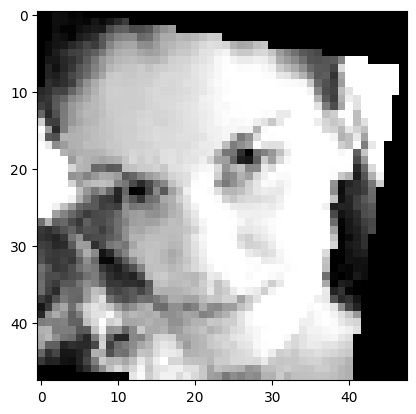

In [13]:
# Visualization setup
dataiter = iter(loaded_train)
images, labels = next(dataiter)
expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display a random image and its label
random_idx = random.randint(0, 63)
print("Target label:", expression[int(labels[random_idx].cpu().numpy())])
plt.imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
plt.show()


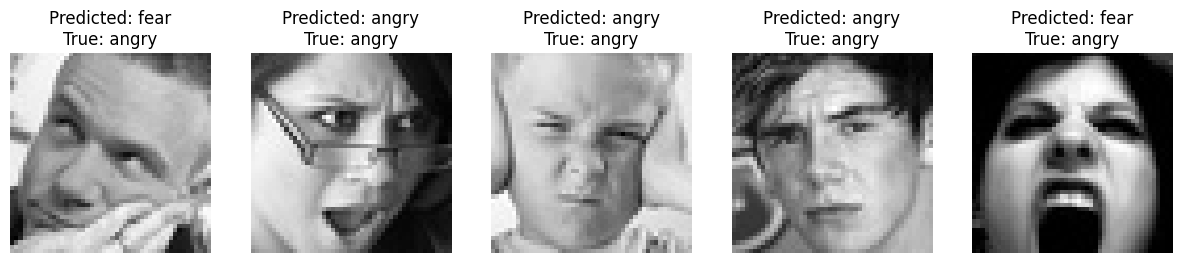

In [14]:
# Evaluate the model and make predictions on 5 random images
model.eval()
dataiter = iter(loaded_validation)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}

# Display 5 random images with their predicted and true labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    random_idx = random.randint(0, len(images) - 1)
    axes[i].imshow(np.transpose(images[random_idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
    axes[i].set_title(f"Predicted: {expression[int(predicted[random_idx].cpu().numpy())]}\nTrue: {expression[int(labels[random_idx].cpu().numpy())]}")
    axes[i].axis('off')
plt.show()